In [3]:
!pip install biopython
!pip install collections
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install itertools
!pip install scipy




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import collections.abc as collections

from functools import partial

import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [2]:
def iflatten(iterable):
    """
    Returns a flattened version of an arbitrarily deeply nested iterable.
    :param iterable: some fixed order iterable (list, tuple)
    :return: generator
    """
    for elt in iterable:
        if isinstance(elt, collections.Iterable) and not isinstance(elt, str):
            for sub in flatten(elt):
                yield sub
        else:
            yield elt

def flatten(iterable):
    return list(iflatten(iterable))

def merge(*sequences):
    return list(map(flatten, zip(*sequences)))

In [7]:
# plt.style.use('seaborn')

# plt.style.use('seaborn')

class Alignment(object):
    def __init__(self, sequences):
        assert all(len(sequence) == len(sequences[0]) for sequence in sequences[1:])
        self.alignment = pd.DataFrame(sequences)
        self.n_samples, self.n_features = self.alignment.shape

    @classmethod
    def from_sequences(cls, *sequences):
        return Alignment(merge(sequences))

    def profile(self, plot=False):
        profile = self.alignment.apply(lambda x: x.value_counts() / x.count()).fillna(0.0)
        if plot:
            profile.T.plot(kind='bar')
        return profile


    def score(self, scoring_fn=None, gap_weight=1.0, gap_penalty=1.0, per_column=False):
        """
        Return the average sum of pairs score over all columns.
        """
        if scoring_fn is None:
            scoring_fn = lambda a, b: 0.0 if a == b else 2.0
        scores = []
        for column in self.alignment.columns:
            score = 0.0
            count = 0.0
            for i in range(self.n_samples):
                for j in range(self.n_samples):
                    if i != j:
                        val_a, val_b = self.alignment[column].values[i], self.alignment[column].values[j]
                        if val_a == '_' and val_b == '_':
                            score += 0.0
                        elif val_a == '_' or val_b == '_':
                            score += gap_weight
                        else:
                            score += 0.0 if scoring_fn(val_a, val_b) < 1 else 1.0
                        count += 1.0
            scores.append(score / count)
        return scores if per_column else sum(scores) / len(scores)

    def _row_based_score(self, scoring_fn=None, gap_weight=1.0, gap_penalty=1.0):
        if scoring_fn is None:
            scoring_fn = lambda a, b: 0.0 if a == b else 2.0
        scores = []
        for i, row in self.alignment.iterrows():
            row_score = []
            for column in self.alignment.columns:
                if row[column] != '_':
                    score, count = 0, 0
                    for j in range(self.n_samples):
                        if j != i:
                            val_a, val_b = self.alignment.ix[i, column], self.alignment.ix[j, column]
                            if val_a == '_' or val_b == '_':
                                score += gap_weight
                            else:
                                score += 0.0 if scoring_fn(val_a, val_b) < 1 else 1.0
                            count += 1.0
                    row_score.append(score / count)
            scores.extend([(pos / len(row_score), score) for pos, score in enumerate(row_score, 1)])

        return scores

    def plot(self, filepath=None):
        """
        Plot the alignment using matplotlib.
        """
    
        unique_values = list(set(value for row in self.alignment.values for value in row))
        colors = iter(plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(unique_values))))
        colors = dict(zip(unique_values, colors))
     
        fig, ax = plt.subplots(figsize=(self.n_features * 1.5, self.n_samples))
        for i, row in self.alignment.iterrows():
            for j, value in enumerate(row.values):
                ax.annotate(value, xy=(j, self.n_samples - i - 1), color=colors[value])
     
        ax.set_yticks(range(self.n_samples))
        ax.set_yticklabels(self.alignment.index)
        ax.set_xticklabels(())
        ax.set_ylim(-1, self.n_samples)
        ax.set_xlim(-1, self.n_features)
        if filepath:
            plt.savefig(filepath + (".pdf" if not filepath.endswith('.pdf') else ''))
            plt.close(fig)



    def __repr__(self):
        return f'<Alignment of {self.n_samples} sequences>'

    def __str__(self):
        return self.alignment.to_string()





In [8]:
NONE, LEFT, UP, DIAG = 0, 1, 2, 3


def clustalw(sequence_a, sequence_b, scorer, gap_penalty=1, scale=1.0):
    """
    :param sequence_a: any iterable with a fixed order.
    :param sequence_b: any iterable with a fixed order.
    :param scorer: a dictionary holding the scores between all pairwise
                   items in sequence_a and sequence_b.
    :param gap_penalty: the gap opening penalty used in the analysis.
    :param scale: the factor by which gap_penalty should be decreased.
    :return: numpy matrix, backtrace pointers and the distance between the
             two sequences.
    """
    len1, len2 = len(sequence_a), len(sequence_b)
    pointer = np.zeros((len1 + 1, len2 + 1), dtype='i')
    matrix = np.zeros((len1 + 1, len2 + 1), dtype='f')
    length = np.zeros((len1 + 1, len2 + 1), dtype='f')
    pointer[0, 0] = NONE
    pointer[0, 1:] = LEFT
    pointer[1:, 0] = UP
    for i in range(1, len1 + 1):
        matrix[i, 0] = matrix[i - 1, 0] + gap_penalty * scale
        length[i, 0] = length[i - 1, 0] + gap_penalty * scale
    for j in range(1, len2 + 1):
        matrix[0, j] = matrix[0, j - 1] + gap_penalty * scale
        length[0, j] = length[0, j - 1] + gap_penalty * scale
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            gap_a = matrix[i - 1, j] + (gap_penalty * scale if pointer[i - 1, j] == UP else gap_penalty)
            gap_b = matrix[i, j - 1] + (gap_penalty * scale if pointer[i, j - 1] == LEFT else gap_penalty)
            match = matrix[i - 1, j - 1] + scorer[i - 1, j - 1]
            if gap_a < match and gap_a <= gap_b:
                matrix[i, j] = gap_a
                pointer[i, j] = UP
            elif match <= gap_b:
                matrix[i, j] = match
                pointer[i, j] = DIAG
            else:
                matrix[i, j] = gap_b
                pointer[i, j] = LEFT
            p = pointer[i, j]
            l_gap_a = length[i - 1, j] + (gap_penalty * scale if p == UP else 0)
            l_gap_b = length[i, j - 1] + (gap_penalty * scale if p == LEFT else 0)
            l_match = length[i - 1, j - 1] + (scorer[i - 1, j - 1] if p == DIAG else 0)
            length[i, j] = max(l_gap_a, l_gap_b, l_match)
   
    distance = matrix[len1, len2] / length[len1, len2]

    return matrix, pointer, distance


def backtrace(pointer, sequence_a, sequence_b):
    i, j = len(sequence_a), len(sequence_b)
    align1, align2 = [], []
    fill_a, fill_b = '_', '_'
    if any(isinstance(e, (tuple, list)) for e in sequence_a):
        fill_a = ('_',) * len(sequence_a[0])
    if any(isinstance(e, (tuple, list)) for e in sequence_b):
        fill_b = ('_',) * len(sequence_b[0])
    while True:
        p = pointer[i, j]
        if p == NONE:
            break
        if p == DIAG:
            align1.append(sequence_a[i - 1])
            align2.append(sequence_b[j - 1])
            i, j = i - 1, j - 1
        elif p == LEFT:
            align1.append(fill_a)
            align2.append(sequence_b[j - 1])
            j -= 1
        elif p == UP:
            align1.append(sequence_a[i - 1])
            align2.append(fill_b)
            i -= 1
        else:
            raise ValueError("Something went terribly wrong.")
    return align1[::-1], align2[::-1]


def align(sequence_a, sequence_b, scores, gap_penalty=1, scale=1.0):
    matrix, pointer, distance = clustalw(
        sequence_a, sequence_b, scores, gap_penalty, scale)
    align1, align2 = backtrace(pointer, sequence_a, sequence_b)
    return align1, align2, distance


def align_sequences(sequence_a, sequence_b, scoring_fn=None, gap_penalty=1, scale=1.0):
    """
    Align two sequences using the Needleman-Wunsch algorithm.

    :param sequence_a: some fixed order iterable.
    :param sequence_b: some fixed order iterable.
    :param scoring_fn: a distance function.
    :param gap_penalty: the penalty for inserting gaps.
    :param scale: the factor by which gap_penalty should be decreased.
    :return: two new sequences with gaps inserted and the distance between them.
    """
    if scoring_fn is None:
        scoring_fn = lambda a, b: 0.0 if a == b else 2.0
    scores = {(i, j): scoring_fn(sequence_a[i], sequence_b[j])
              for i in range(len(sequence_a)) for j in range(len(sequence_b))}
    return align(sequence_a, sequence_b, scores, gap_penalty, scale)


def _align_profiles(sequence_a, sequence_b, scoring_fn=None,
                    gap_penalty=1, scale=1.0, gap_weight=0.5):
    scores = {}
    for i in range(len(sequence_a)):
        for j in range(len(sequence_b)):
            dist = 0.0
            count = 0.0
            for k in range(len(sequence_a[i])):
                for l in range(len(sequence_b[j])):
                    mi = sequence_a[i][k]
                    mj = sequence_b[j][l]
                    if mi == '_' or mj == '_':
                        dist += gap_weight
                    else:
                        dist += 0.0 if scoring_fn(mi, mj) < 1 else 1.0
                    count += 1.0
                scores[i, j] = dist / count
    return align(sequence_a, sequence_b, scores, gap_penalty, scale)


def pairwise_distances(sequences, fn):
    distances = np.zeros((len(sequences), len(sequences)))
    for i in range(len(sequences)):
        for j in range(i):
            _, _, distance = fn(sequences[i], sequences[j])
            distances[i, j] = distance
            distances[j, i] = distances[i, j]

    return distances


def multi_sequence_alignment(sequences, scoring_fn=None, linking='single',
                             gap_penalty=1, scale= 1.0, gap_weight=1.0, verbosity=0):
    """
    Perform progressive multiple sequence alignment.

    :param sequences: some iterable of fixed order iterables.
    :param scoring_fn: a distance function.
    :param linkage: the linkage function to use for the clustering.
    :return: an Alignment object.
    """
    if scoring_fn is None:
        scoring_fn = lambda a, b: 0.0 if a == b else 2.0

    
    matrix = pairwise_distances(sequences, partial(align_sequences, scoring_fn=scoring_fn,
                                                   gap_penalty=gap_penalty, scale=scale))

    
    Z = linkage(squareform(matrix), method='single')

   
    alignments = {}
    n_seqs = len(sequences)
    for cluster_id, (node1, node2, _, _) in enumerate(Z, n_seqs):
        node1, node2 = int(node1), int(node2)
        if node1 < n_seqs and node2 < n_seqs:
            align1, align2, _ = align_sequences(sequences[node1], sequences[node2],
                                                scoring_fn, gap_penalty, scale)
        else:
            if node1 < n_seqs:
                sequence_a, sequence_b = [[elt] for elt in sequences[node1]], alignments[node2]
            elif node2 < n_seqs:
                sequence_a, sequence_b = alignments[node1], [[elt] for elt in sequences[node2]]
            else:
                sequence_a, sequence_b = alignments[node1], alignments[node2]
            align1, align2, _ = _align_profiles(sequence_a, sequence_b, scoring_fn, gap_penalty, scale, gap_weight)
        alignments[cluster_id] = merge(align1, align2)
    return matrix, Alignment(list(zip(*map(flatten, alignments[max(alignments)]))))

def guide_tree(self, alignment, filepath=None):
    """
        Generate and plot the guide tree using scipy's dendrogram function.
        """
    

    distances = pairwise_distances(list(self.alignment.values), align_sequences)

    linkage_matrix = linkage(squareform(distances), method='single')


    dendrogram(linkage_matrix, labels=self.alignment.index, orientation='top', distance_sort='descending', above_threshold_color='k')
    plt.xlabel('Distance')
    plt.ylabel('Sequences')
    plt.title('Guide Tree')
    if filepath:
        plt.savefig(filepath + (".pdf" if not filepath.endswith('.pdf') else ''))
        plt.close()
    else:
        plt.show()



In [9]:
__all__ = ['align_sequences', 'multi_sequence_alignment', 'Alignment']


Input Sequence
GARFIELD-THE-LAST-FAT-CAT
GARFIELD-THE-FAST-CAT
GARFIELD-THE-VERY-FAST-CAT
THE-FAT-CAT


Distance Matrix 
 [[0.         0.23076923 0.30000001 0.56      ]
 [0.23076923 0.         0.1923077  0.47619048]
 [0.30000001 0.1923077  0.         0.57692307]
 [0.56       0.47619048 0.57692307 0.        ]]


Output - Multiple Sequence Alignment values :
   0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
0  _  _  _  _  _  _  _  _  _  T  H  E  _  _  _  _  _  -  F  A  _  T  -  C  A  T
1  G  A  R  F  I  E  L  D  -  T  H  E  -  L  A  S  T  -  F  A  _  T  -  C  A  T
2  G  A  R  F  I  E  L  D  -  T  H  _  _  _  E  _  _  -  F  A  S  T  -  C  A  T
3  G  A  R  F  I  E  L  D  -  T  H  E  -  V  E  R  Y  -  F  A  S  T  -  C  A  T


Alignment score =  0.37179487179487175


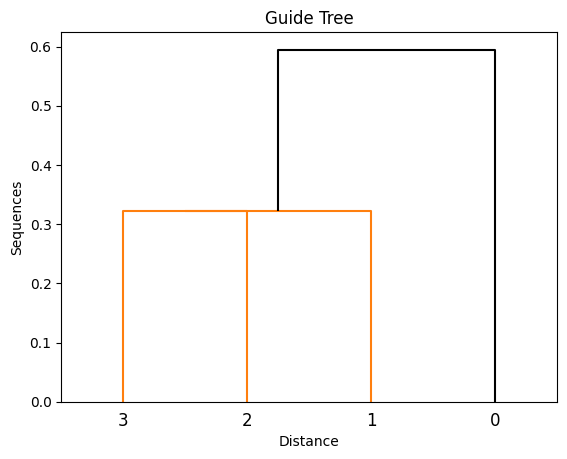

In [11]:
if __name__ == '__main__':
    a = 'GARFIELD-THE-LAST-FAT-CAT'
    b = 'GARFIELD-THE-FAST-CAT'
    c = 'GARFIELD-THE-VERY-FAST-CAT'
    d = 'THE-FAT-CAT'
    input_seq = [a,b,c,d]

    # sequences = ['GARFIELD THE LAST FAT CAT'.split(),
    #              'GARFIELD THE FAST CAT'.split(),
    #              'GARFIELD THE VERY FAST CAT'.split(),
    #              'THE FAT CAT'.split()]

    print("Input Sequence")
    for seq in input_seq:
        print(seq[:])

    matrix, alignment = multi_sequence_alignment(input_seq)
    print("\n")

    print("Distance Matrix \n", matrix )
    print("\n")

    print("Output - Multiple Sequence Alignment values :\n", alignment)
    print("\n")

    print("Alignment score = ", alignment.score())

    guide_tree(alignment, "guide_tree.pdf")